In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
import seaborn as sns
import numpy as np

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam

from keras.layers import Dense, Wrapper
import keras.backend as K
import tensorflow as tf


Using TensorFlow backend.


In [4]:
# sys.path.append(os.path.expanduser("~/projects/2019-SIdropout/"))
sys.path.extend([os.path.expanduser('..')])

from sitools import protocols
from sitools.layers import PruneConnect
from sitools.optimizers import KOOptimizer
from sitools.keras_utils import LossHistory

In [5]:


# class TargetDropConnect(Wrapper):
#     def __init__(self, layer, prob=0.5, **kwargs):
#         self.prob  = prob
#         self.layer = layer
#         super(TargetDropConnect, self).__init__(layer, **kwargs)
#         if 0. < self.prob < 1.:
#             self.uses_learning_phase = True

#     def build(self, input_shape):
#         if not self.layer.built:
#             self.layer.build(input_shape)
#             self.layer.built = True
#             self.kernel = self.layer.kernel
#             self.bias = self.layer.bias
#             self.kernel_rates = self.prob*K.ones_like(self.kernel)
#             self.bias_rates = self.prob*K.ones_like(self.bias)
#         super(TargetDropConnect, self).build()

#     def compute_output_shape(self, input_shape):
#         return self.layer.compute_output_shape(input_shape)
    
#     def get_mask(self,x,prob):
#         mask = (K.random_uniform(prob.shape)>prob)
#         mask = K.cast(mask, x.dtype)/(1e-6+(1.0-prob))
#         return mask
    
#     def get_prune_mask(self,x,thr):
#         mask = (x>thr)
#         mask = K.cast(mask, x.dtype)
#         return mask

#     def call(self, x):
#         self.kernel_mask = self.get_mask(self.kernel, self.kernel_rates)
#         self.bias_mask = self.get_mask(self.bias, self.bias_rates)
        
#         if 0. < self.prob < 1.:
#             self.layer.kernel = K.in_train_phase(self.kernel*self.kernel_mask, self.kernel)
#             self.layer.bias   = K.in_train_phase(self.bias*self.bias_mask, self.bias)
# #             self.layer.kernel = self.kernel*self.kernel_mask
# #             self.layer.bias   = self.bias*self.bias_mask
#         return self.layer.call(x)

In [6]:
batch_size = 128
num_classes = 10
epochs = 10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(PruneConnect(Dense(300, activation='relu'), input_shape=(784,)))
# model.add(Dropout(0.2))
model.add(PruneConnect(Dense(100, activation='relu')))
# model.add(Dropout(0.2))
model.add(PruneConnect(Dense(num_classes, activation='softmax')))

60000 train samples
10000 test samples
Instructions for updating:
Colocations handled automatically by placer.


In [7]:


protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
oopt = KOOptimizer(opt, model=model, **protocol)
model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])


model._make_train_function()
    # saved_weights = model.get_weights()

history = LossHistory()
callbacks = [history]

# model.build()
# model.summary()

overall_history = []
overall_sparseness = []

for k,l in enumerate(model.layers):
    print("Layer %i sparseness %f"%(k,K.get_value(l.get_sparseness())))

reductions = [0.5, 0.9, 0.95, 0.99, 0.995, 0.999]
for e,ptile in enumerate(reductions):
    
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=2,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks)
    oopt.update_task_vars()
    
    # implement dropout strategy after every epoch
    omegas = K.concatenate([ K.flatten(oopt.vars['grads2'][l.kernel]) for l in model.layers ])
    thr = tf.contrib.distributions.percentile(omegas,100*ptile)
    print("Importance cutoff %f"%K.get_value(thr))
    
    for k,l in enumerate(model.layers):
        omega = oopt.vars['grads2'][l.kernel]
        if ptile<1.0:
            mask = omega>thr
        else:
            print("Crude control")
            mask = K.zeros_like(l.kernel)
        l.set_kernel_mask(mask)
        print("Layer %i sparseness %f"%(k,K.get_value(l.get_sparseness())))
        # print("Number of parameters %i"%K.get_value(l.get_nb_parameters()))
    
    # compute overall sparseness
    nb_nz = np.sum([ K.get_value(l.get_nz_parameters()) for l in model.layers ])
    nb_tot = np.sum([ K.get_value(l.get_nb_parameters()) for l in model.layers ])
    overall_history.extend(history.history["acc"])
    overall_sparseness.append(nb_nz/nb_tot)
    print("Overall sparsetiy %f"%(nb_nz/nb_tot))
    
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# compute overall sparseness
nb_nz = np.sum([ K.get_value(l.get_nz_parameters()) for l in model.layers ])
nb_tot = np.sum([ K.get_value(l.get_nb_parameters()) for l in model.layers ])
print("Overall sparsenss: %f"%(nb_nz/nb_tot))

Instructions for updating:
Use tf.cast instead.
Layer 0 sparseness 1.000000
Layer 1 sparseness 1.000000
Layer 2 sparseness 1.000000
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 4s - loss: 0.2753 - acc: 0.9197 - val_loss: 0.1265 - val_acc: 0.9606
Epoch 2/10
 - 3s - loss: 0.1037 - acc: 0.9687 - val_loss: 0.0887 - val_acc: 0.9719
Epoch 3/10
 - 3s - loss: 0.0678 - acc: 0.9790 - val_loss: 0.0790 - val_acc: 0.9758
Epoch 4/10
 - 3s - loss: 0.0487 - acc: 0.9848 - val_loss: 0.0780 - val_acc: 0.9753
Epoch 5/10
 - 3s - loss: 0.0355 - acc: 0.9891 - val_loss: 0.0681 - val_acc: 0.9781
Epoch 6/10
 - 3s - loss: 0.0285 - acc: 0.9913 - val_loss: 0.0702 - val_acc: 0.9798
Epoch 7/10
 - 3s - loss: 0.0198 - acc: 0.9938 - val_loss: 0.0851 - val_acc: 0.9752
Epoch 8/10
 - 3s - loss: 0.0191 - acc: 0.9937 - val_loss: 0.0778 - val_acc: 0.9770
Epoch 9/10
 - 3s - loss: 0.0147 - acc: 0.9953 - val_loss: 0.0717 - val_acc: 0.9794
Epoch 10/10
 - 3s - loss: 0.0105 - acc: 0.9970 - val_loss: 0.0813 - val

In [8]:
# compute overall sparseness
nb_nz = np.sum([ K.get_value(l.get_nz_parameters()) for l in model.layers ])
nb_tot = np.sum([ K.get_value(l.get_nb_parameters()) for l in model.layers ])
print("Overall sparsenss: %f"%(nb_nz/nb_tot))

Overall sparsenss: 0.002536


In [9]:
# K.get_value(model.layers[1].kernel)

In [10]:
# plt.hist(np.ravel(K.get_value(model.layers[1].kernel_mask)))

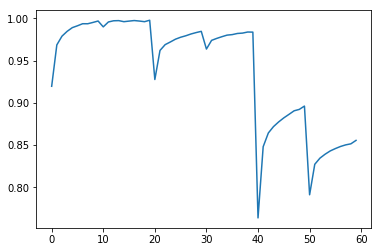

In [11]:
# oopt.update_task_vars()
# lc=np.concatenate(overall_history,axis=0)
plt.plot(overall_history)
# plt.plot(overall_sparseness)

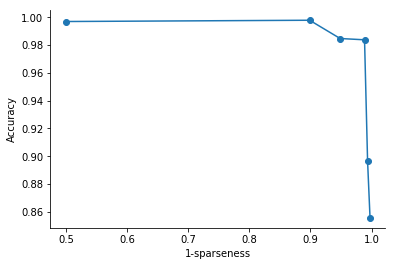

In [12]:
plt.plot(1.0-np.array(overall_sparseness),overall_history[epochs-1::epochs],'o-')
plt.xlabel("1-sparseness")
plt.ylabel("Accuracy")
sns.despine()

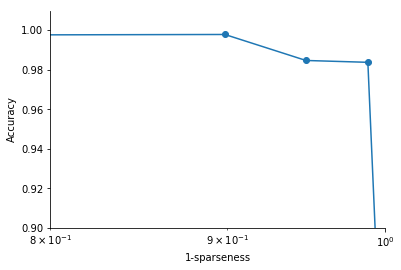

In [13]:
plt.semilogx(1.0-np.array(overall_sparseness),overall_history[epochs-1::epochs],'o-')
plt.xlabel("1-sparseness")
plt.ylabel("Accuracy")
plt.xlim(0.8,1.00)
plt.ylim(0.9,1.01)
sns.despine()

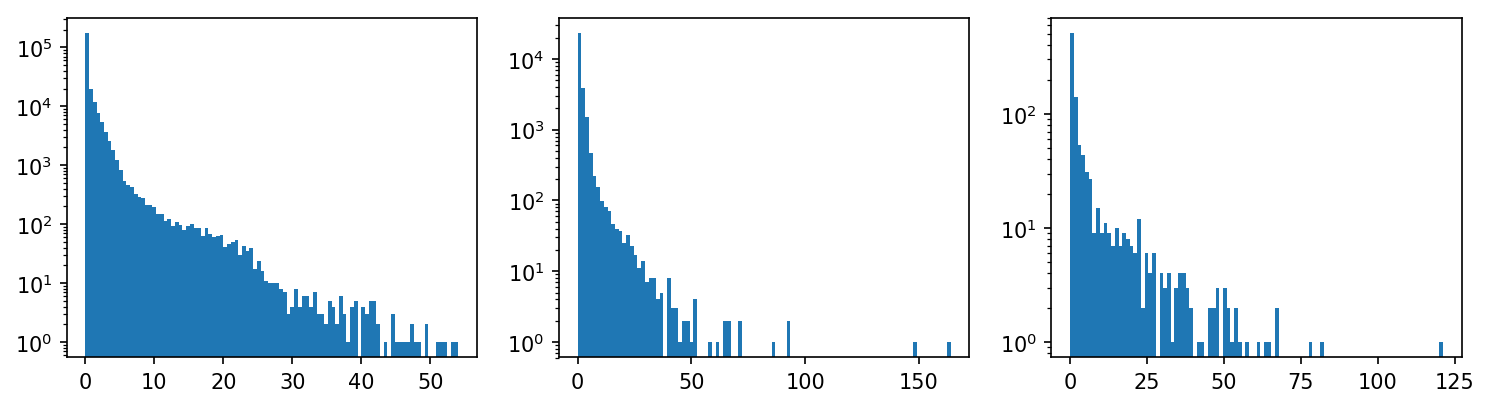

In [14]:
a = len(model.layers)
gs=GridSpec(1,a)
fig=plt.figure(figsize=(12,3),dpi=150)
for i in range(a):
    tmp=oopt.vars['omega'][model.layers[i].weights[0]]
    tmp=K.get_value(tmp)
    ax=plt.subplot(gs[i])
    h1=ax.hist(tmp.ravel(),bins=100,log=True)

# Train a convnet on CIFAR10

In [15]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(PruneConnect(Conv2D(32, (3, 3), padding='same'),
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(PruneConnect(Conv2D(32, (3, 3))))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(PruneConnect(Conv2D(64, (3, 3), padding='same')))
model.add(Activation('relu'))
model.add(PruneConnect(Conv2D(64, (3, 3))))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(PruneConnect(Dense(512)))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(PruneConnect(Dense(num_classes)))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255





x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [16]:
protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
oopt = KOOptimizer(opt, model=model, **protocol)
model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])


model._make_train_function()
    # saved_weights = model.get_weights()

history = LossHistory()
callbacks = [history]

# model.build()
# model.summary()

overall_history = []
overall_sparseness = []

for k,l in enumerate(model.layers):
    if type(l)!=PruneConnect: continue
    print("Layer %i sparseness %f"%(k,K.get_value(l.get_sparseness())))

reductions = [0.5, 0.9, 0.95, 0.99, 0.995, 0.999]
for e,ptile in enumerate(reductions):
    
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=2,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks)
    oopt.update_task_vars()
    
    # implement dropout strategy after every epoch
    omegas = K.concatenate([ K.flatten(oopt.vars['grads2'][l.kernel]) for l in model.layers if type(l)==PruneConnect ])
    thr = tf.contrib.distributions.percentile(omegas,100*ptile)
    print("Importance cutoff %f"%K.get_value(thr))
    
    for k,l in enumerate(model.layers):
        if type(l)!=PruneConnect: continue
        omega = oopt.vars['grads2'][l.kernel]
        if ptile<1.0:
            mask = omega>thr
        else:
            print("Crude control")
            mask = K.zeros_like(l.kernel)
        l.set_kernel_mask(mask)
        print("Layer %i sparseness %f"%(k,K.get_value(l.get_sparseness())))
        # print("Number of parameters %i"%K.get_value(l.get_nb_parameters()))
    
    # compute overall sparseness
    nb_nz = np.sum([ K.get_value(l.get_nz_parameters()) for l in model.layers if type(l)==PruneConnect ])
    nb_tot = np.sum([ K.get_value(l.get_nb_parameters()) for l in model.layers if type(l)==PruneConnect])
    overall_history.extend(history.history["acc"])
    overall_sparseness.append(nb_nz/nb_tot)
    print("Overall sparsetiy %f"%(nb_nz/nb_tot))
    
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# compute overall sparseness
nb_nz = np.sum([ K.get_value(l.get_nz_parameters()) for l in model.layers if type(l)==PruneConnect])
nb_tot = np.sum([ K.get_value(l.get_nb_parameters()) for l in model.layers if type(l)==PruneConnect])
print("Overall sparsenss: %f"%(nb_nz/nb_tot))

Layer 0 sparseness 1.000000
Layer 2 sparseness 1.000000
Layer 5 sparseness 1.000000
Layer 7 sparseness 1.000000
Layer 11 sparseness 1.000000
Layer 13 sparseness 1.000000
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 20s - loss: 1.3899 - acc: 0.4949 - val_loss: 1.0778 - val_acc: 0.6176
Epoch 2/10
 - 20s - loss: 0.9272 - acc: 0.6734 - val_loss: 0.8510 - val_acc: 0.7026
Epoch 3/10
 - 20s - loss: 0.7104 - acc: 0.7522 - val_loss: 0.7656 - val_acc: 0.7359
Epoch 4/10
 - 20s - loss: 0.5600 - acc: 0.8048 - val_loss: 0.7554 - val_acc: 0.7484
Epoch 5/10
 - 20s - loss: 0.4314 - acc: 0.8487 - val_loss: 0.8054 - val_acc: 0.7437
Epoch 6/10
 - 20s - loss: 0.3115 - acc: 0.8886 - val_loss: 0.8740 - val_acc: 0.7468
Epoch 7/10
 - 20s - loss: 0.2198 - acc: 0.9226 - val_loss: 0.9995 - val_acc: 0.7420
Epoch 8/10
 - 20s - loss: 0.1675 - acc: 0.9415 - val_loss: 1.1778 - val_acc: 0.7415
Epoch 9/10
 - 20s - loss: 0.1362 - acc: 0.9528 - val_loss: 1.3071 - val_acc: 0.7389
Epoch 10/10
 - 20s - los

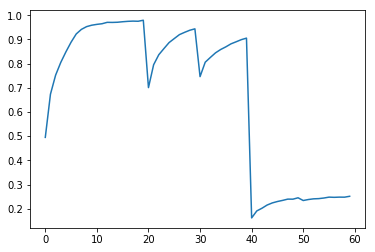

In [18]:
# oopt.update_task_vars()
# lc=np.concatenate(overall_history,axis=0)
plt.plot(overall_history)
# plt.plot(overall_sparseness)

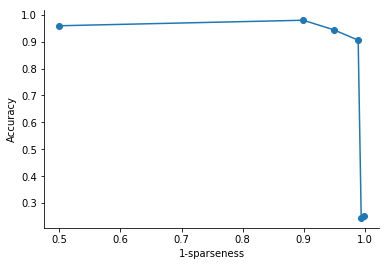

In [19]:
plt.plot(1.0-np.array(overall_sparseness),overall_history[epochs-1::epochs],'o-')
plt.xlabel("1-sparseness")
plt.ylabel("Accuracy")
sns.despine()

In [17]:
print(1/0)

ZeroDivisionError: division by zero

# End of usable code

In [ ]:
import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from sitools import utils
import seaborn as sns
sns.set_style("ticks")

from tqdm import trange, tqdm

# import operator
import matplotlib.colors as colors
import matplotlib.cm as cmx

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

## Parameters

In [ ]:
select = tf.select if hasattr(tf, 'select') else tf.where

In [ ]:
# Data params
input_dim = 784
output_dim = 10

# Network params
n_hidden_units = 256
activation_fn = tf.nn.relu

# Optimization params
batch_size = 64
epochs_per_task = 10

n_stats = 10

# Reset optimizer after each age
reset_optimizer = True

## Construct datasets

In [ ]:
task_labels = [[0,1], [2,3]]#, [4,5], [6,7], [8,9]]
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
# task_labels = [[0,1,2,3,4], [5,6,7,8,9]]
n_tasks = len(task_labels)
training_datasets = utils.construct_split_mnist(task_labels, split='train')
validation_datasets = utils.construct_split_mnist(task_labels, split='test')
# training_datasets = utils.mk_training_validation_splits(full_datasets, split_fractions=(0.9, 0.1))

## Construct network, loss, and updates

In [ ]:
tf.reset_default_graph()

In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

In [ ]:
# tf.equal(output_mask[None, :], 1.0)

In [ ]:
import keras.backend as K
import keras.activations as activations

output_mask = tf.Variable(tf.zeros(output_dim), name="mask", trainable=False)

def masked_softmax(logits):
    # logits are [batch_size, output_dim]
    x = select(tf.tile(tf.equal(output_mask[None, :], 1.0), [tf.shape(logits)[0], 1]), logits, -1e32 * tf.ones_like(logits))
    return activations.softmax(x)

def set_active_outputs(labels):
    new_mask = np.zeros(output_dim)
    for l in labels:
        new_mask[l] = 1.0
    sess.run(output_mask.assign(new_mask))
    print(sess.run(output_mask))
    
def masked_predict(model, data, targets):
    pred = model.predict(data)
    print(pred)
    acc = np.argmax(pred,1)==np.argmax(targets,1)
    return acc.mean()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(n_hidden_units, activation=activation_fn, input_shape=(input_dim,)))
model.add(Dense(n_hidden_units, activation=activation_fn))
model.add(Dense(output_dim, kernel_initializer='zero', activation=masked_softmax))

In [ ]:
from sitools import protocols
from sitools.optimizers import KOOptimizer
from keras.optimizers import Adam, RMSprop,SGD
from keras.callbacks import Callback
from sitools.keras_utils import LossHistory

#protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
# protocol_name, protocol = protocols.SUM_FISHER_PROTOCOL('sum')
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
# opt = SGD(1e-3)
# opt = RMSprop(lr=1e-3)
oopt = KOOptimizer(opt, model=model, **protocol)
model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])
model._make_train_function()
saved_weights = model.get_weights()

history = LossHistory()
callbacks = [history]
datafile_name = "split_mnist_data_%s.pkl.gz"%protocol_name

## Train!

In [ ]:
# diag_vals = dict()
# all_evals = dict()
# data = utils.load_zipped_pickle("comparison_data_%s.pkl.gz"%protocol_name)
# returns empty dict if file not found

def run_fits(cvals, training_data, valid_data, eval_on_train_set=False, nstats=1):
    acc_mean = dict()
    acc_std = dict()
    for cidx, cval_ in enumerate(tqdm(cvals)):
        runs = []
        for runid in range(nstats):
            sess.run(tf.global_variables_initializer())
            # model.set_weights(saved_weights)
            cstuffs = []
            evals = []
            print("setting cval")
            cval = cval_
            oopt.set_strength(cval)
            oopt.init_task_vars()
            print("cval is", sess.run(oopt.lam))
            for age, tidx in enumerate(range(n_tasks)):
                print("Age %i, cval is=%f"%(age,cval))
                print("settint output mask")
                set_active_outputs(task_labels[age])
                stuffs = model.fit(training_data[tidx][0], training_data[tidx][1], batch_size, epochs_per_task, callbacks=callbacks)
                oopt.update_task_metrics(training_data[tidx][0], training_data[tidx][1], batch_size)
                oopt.update_task_vars()
                ftask = []
                for j in range(n_tasks):
                    set_active_outputs(task_labels[j])
                    if eval_on_train_set:
                        f_ = masked_predict(model, training_data[j][0], training_data[j][1])
                    else:
                        f_ = masked_predict(model, valid_data[j][0], valid_data[j][1])
                    ftask.append(np.mean(f_))
                evals.append(ftask)
                cstuffs.append(stuffs)

                # Re-initialize optimizater variables
                if reset_optimizer:
                    oopt.reset_optimizer()

            evals = np.array(evals)
            runs.append(evals)
        
        runs = np.array(runs)
        acc_mean[cval_] = runs.mean(0)
        acc_std[cval_] = runs.std(0)
    return dict(mean=acc_mean, std=acc_std)


In [ ]:
# cvals = np.concatenate(([0], np.logspace(-2, 2, 10)))
# cvals = np.concatenate(([0], np.logspace(-1, 2, 2)))
# cvals = np.concatenate(([0], np.logspace(-2, 0, 3)))
cvals = np.logspace(-3, 3, 7)#[0, 1.0, 2, 5, 10]
cvals = [0, 1.0]
print(cvals)


In [ ]:
%%capture

recompute_data = True

if recompute_data:
    data = run_fits(cvals, training_datasets, validation_datasets, eval_on_train_set=True, nstats=n_stats)
    utils.save_zipped_pickle(data, datafile_name)

In [ ]:
data = utils.load_zipped_pickle(datafile_name)
print(cvals)

In [ ]:
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=-5, vmax=np.log(np.max(list(data['mean'].keys()))))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
print(scalarMap.get_clim())

In [ ]:
figure(figsize=(14, 2.5))
axs = [subplot(1,n_tasks+1,1)]#, None, None]
for i in range(1, n_tasks + 1):
    axs.append(subplot(1, n_tasks+1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(cval))
        # axs[j].plot(evals[:, j], c=colorVal)
        axs[j].errorbar(range(n_tasks), mean_vals[:, j], yerr=std_vals[:, j]/np.sqrt(n_stats), c=colorVal)
    label = "c=%g"%cval
    average = mean_vals.mean(1)
    axs[-1].plot(average, c=colorVal, label=label)
    
for i, ax in enumerate(axs):
    ax.legend(loc='best')
    ax.set_title((['task %d'%j for j in range(n_tasks)] + ['average'])[i])
gcf().tight_layout()
sns.despine()

In [ ]:
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [ ]:
fig = plt.figure(figsize=(3.3,2.5))
ax = plt.subplot(111)

for cval in sorted_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    # plot(range(1,n_tasks+1), mean_stuff, 'o-', label="c=%g"%cval)
    errorbar(range(1,n_tasks+1), mean_stuff, yerr=std_stuff, fmt='o-', label="c=%g"%cval)
        
axhline(data['mean'][cval][0][0], linestyle='--', color='k')
xlabel('Number of tasks')
ylabel('Fraction correct')
legend(loc='best')
xlim(0.5, 5.5)
ylim(0.7, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)

In [ ]:
fig = plt.figure(figsize=(3.3,2.0))
ax = plt.subplot(111)

plot_keys =sorted(data['mean'].keys())# [0,1]

for cval in plot_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    # plot(range(1,n_tasks+1), mean_stuff, 'o-', label="c=%g"%cval)
    errorbar(range(1,n_tasks+1), mean_stuff, yerr=std_stuff, fmt='o-', label="c=%g"%cval)
        
axhline(data['mean'][cval][0][0], linestyle=':', color='k')
xlabel('Number of tasks')
ylabel('Fraction correct')
legend(loc='best', fontsize=8)
xlim(0.5, 5.5)
plt.yticks([0.6,0.8,1.0])
ylim(0.6, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)
plt.subplots_adjust(left=.15, bottom=.18, right=.99, top=.97)
plt.savefig("split_mnist_accuracy.pdf")

In [ ]:
figure(figsize=(7, 1.8))
axs = [subplot(1,n_tasks+1,1)]
for i in range(1,n_tasks+1):
    axs.append(subplot(1, n_tasks+1, i+1, sharex=axs[0], sharey=axs[0]))
fmts = ['o', 's']

plot_keys =sorted(data['mean'].keys())
# plot_keys = [0]
print(plot_keys)

for i, cval in enumerate(plot_keys):
    label = "c=%g"%cval
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks+1):
        sca(axs[j])
        errorbar_kwargs = dict(fmt="%s-"%fmts[i], markersize=5)
        if j < n_tasks:
            # print(j,mean_vals[:, j])
            norm= np.sqrt(n_stats) # np.sqrt(n_stats) for SEM or 1 for STDEV
            axs[j].errorbar(np.arange(n_tasks)+1, mean_vals[:, j], yerr=std_vals[:, j]/norm, label=label, **errorbar_kwargs)
        else:
            mean_stuff = []
            std_stuff = []
            for i in range(len(data['mean'][cval])):
                mean_stuff.append(data['mean'][cval][i][:i+1].mean())
                #std_stuff.append(data['mean'][cval][i][:i+1].std()/np.sqrt(n_stats))
                std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
            # plot(range(1,n_tasks+1), mean_stuff, 'o-', label="c=%g"%cval)
            errorbar(range(1,n_tasks+1), mean_stuff, yerr=std_stuff, label="c=%g"%cval, **errorbar_kwargs)
        plt.xticks(np.arange(5)+1)
        plt.xlim((1.0,5.5))
        if j == 0:
            axs[j].set_yticks([0.5,1])
        else:
            setp(axs[j].get_yticklabels(), visible=False)
        plt.ylim((0.45,1.1))

for i, ax in enumerate(axs):
    if i < n_tasks:
        ax.set_title((['Task %d (%d or %d)'%(j+1,task_labels[j][0], task_labels[j][1]) for j in range(n_tasks)] + ['average'])[i], fontsize=8)
    else:
        ax.set_title("Average", fontsize=8)
    #ax.set_title((['Task %d'%(j+1) for j in xrange(n_tasks)] + ['average'])[i], fontsize=8)
    # ax.axhline(0.5, linestyle=':', color='k')
    ax.axhline(0.5, color='k', linestyle=':', label="chance", zorder=0)
handles, labels = axs[-1].get_legend_handles_labels()
# Reorder legend so chance is last
axs[-1].legend([handles[j] for j in [1,2,0]], [labels[j] for j in [1,2,0]], loc='lower right', fontsize=8, bbox_to_anchor=(-1.3, -.7), ncol=3, frameon=True)
# axs[-1].legend(loc='lower right', fontsize=8, bbox_to_anchor=(-1.3, -.7), ncol=3, frameon=True)
    
axs[0].set_xlabel("Tasks")
axs[0].set_ylabel("Accuracy")
gcf().tight_layout()
sns.despine()
plt.savefig("split_mnist_tasks.pdf")